In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
mpl.rcParams["font.family"] = 'NanumBarunGothic'
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import files
uploaded=files.upload()

Saving feature_15.csv.txt to feature_15.csv.txt


In [4]:
import io
data=pd.read_csv(io.BytesIO(uploaded['feature_15.csv.txt']))

In [5]:
data.head()

,Date,Open,High,Low,Close,Volume,nasdaq,exchange,Semiconductor,foreign,institution,KOSPI,Korea_bond_1year,PBR,PER,ROE
0,2018-01-02,51380.0,51400.0,50780.0,51020.0,169485.0,7006.90,1067.23,1287.70,-23405.0,-18019.0,2479.65,1.816,0.037682,0.265244,0.142064
1,2018-01-03,52540.0,52560.0,51420.0,51620.0,200270.0,7065.53,1062.88,1309.86,-47563.0,45759.0,2486.35,1.792,0.038125,0.268364,0.142064
2,2018-01-04,52120.0,52180.0,50640.0,51080.0,233909.0,7077.91,1064.84,1317.24,-39755.0,26643.0,2466.46,1.800,0.037726,0.265556,0.142064
3,2018-01-05,51300.0,52120.0,51200.0,52120.0,189623.0,7136.56,1063.33,1325.71,5786.0,9550.0,2497.52,1.781,0.038494,0.270963,0.142064
4,2018-01-08,52400.0,52520.0,51500.0,52020.0,167673.0,7157.39,1062.27,1335.54,-17940.0,9060.0,2513.28,1.789,0.038420,0.270443,0.142064


In [7]:
df=data
df=df[df['Open']!=0]

In [8]:

df.fillna(0, inplace=True)

In [9]:
idx = df.index[df['Date'] <= '2018-04-30'][-1]
df['Volume'].iloc[:idx] = df['Volume'].iloc[:idx]*50

In [10]:
df.head()

,Date,Open,High,Low,Close,Volume,nasdaq,exchange,Semiconductor,foreign,institution,KOSPI,Korea_bond_1year,PBR,PER,ROE
0,2018-01-02,51380.0,51400.0,50780.0,51020.0,8474250.0,7006.90,1067.23,1287.70,-23405.0,-18019.0,2479.65,1.816,0.037682,0.265244,0.142064
1,2018-01-03,52540.0,52560.0,51420.0,51620.0,10013500.0,7065.53,1062.88,1309.86,-47563.0,45759.0,2486.35,1.792,0.038125,0.268364,0.142064
2,2018-01-04,52120.0,52180.0,50640.0,51080.0,11695450.0,7077.91,1064.84,1317.24,-39755.0,26643.0,2466.46,1.800,0.037726,0.265556,0.142064
3,2018-01-05,51300.0,52120.0,51200.0,52120.0,9481150.0,7136.56,1063.33,1325.71,5786.0,9550.0,2497.52,1.781,0.038494,0.270963,0.142064
4,2018-01-08,52400.0,52520.0,51500.0,52020.0,8383650.0,7157.39,1062.27,1335.54,-17940.0,9060.0,2513.28,1.789,0.038420,0.270443,0.142064


In [ ]:
df.set_index('Date',inplace=True)

In [ ]:
df.head()


,Open,High,Low,Close,Volume,nasdaq,exchange,Semiconductor,foreign,institution,KOSPI,Korea_bond_1year,PBR,PER,ROE,5days,10days,20days,60days
Date,,,,,,,,,,,,,,,,,,,
2018-01-02,51380.0,51400.0,50780.0,51020.0,8474250.0,7006.90,1067.23,1287.70,-23405.0,-18019.0,2479.65,1.816,0.037682,0.265244,0.142064,0.0,0.0,0.0,0.0
2018-01-03,52540.0,52560.0,51420.0,51620.0,10013500.0,7065.53,1062.88,1309.86,-47563.0,45759.0,2486.35,1.792,0.038125,0.268364,0.142064,0.0,0.0,0.0,0.0
2018-01-04,52120.0,52180.0,50640.0,51080.0,11695450.0,7077.91,1064.84,1317.24,-39755.0,26643.0,2466.46,1.800,0.037726,0.265556,0.142064,0.0,0.0,0.0,0.0
2018-01-05,51300.0,52120.0,51200.0,52120.0,9481150.0,7136.56,1063.33,1325.71,5786.0,9550.0,2497.52,1.781,0.038494,0.270963,0.142064,0.0,0.0,0.0,0.0
2018-01-08,52400.0,52520.0,51500.0,52020.0,8383650.0,7157.39,1062.27,1335.54,-17940.0,9060.0,2513.28,1.789,0.038420,0.270443,0.142064,51572.0,0.0,0.0,0.0


In [11]:

df.drop('exchange', axis=1, inplace=True)
df.drop('foreign', axis=1, inplace=True)
df.drop('institution', axis=1, inplace=True)
df.drop('Korea_bond_1year', axis=1, inplace=True)
df.drop('PBR', axis=1, inplace=True)
df.drop('PER', axis=1, inplace=True)
df.drop('ROE', axis=1, inplace=True)
df.head()


,Date,Open,High,Low,Close,Volume,nasdaq,Semiconductor,KOSPI
0,2018-01-02,51380.0,51400.0,50780.0,51020.0,8474250.0,7006.90,1287.70,2479.65
1,2018-01-03,52540.0,52560.0,51420.0,51620.0,10013500.0,7065.53,1309.86,2486.35
2,2018-01-04,52120.0,52180.0,50640.0,51080.0,11695450.0,7077.91,1317.24,2466.46
3,2018-01-05,51300.0,52120.0,51200.0,52120.0,9481150.0,7136.56,1325.71,2497.52
4,2018-01-08,52400.0,52520.0,51500.0,52020.0,8383650.0,7157.39,1335.54,2513.28


In [12]:
scaler=MinMaxScaler()
scale_cols=["Open", "High", "Low", "Close", "Volume", "nasdaq", 
                      "Semiconductor", 'KOSPI']
df_scaled=scaler.fit_transform(df[scale_cols])

In [13]:
df_scaled=pd.DataFrame(df_scaled)
df_scaled.columns=scale_cols
print(df_scaled)

         Open    High       Low  ...    nasdaq  Semiconductor     KOSPI
0    0.567413  0.5520  0.572074  ...  0.206675       0.233419  0.896068
1    0.614664  0.5984  0.598357  ...  0.221562       0.257113  0.901942
2    0.597556  0.5832  0.566324  ...  0.224705       0.265004  0.884503
3    0.564155  0.5808  0.589322  ...  0.239597       0.274060  0.911736
4    0.608961  0.5968  0.601643  ...  0.244886       0.284570  0.925553
..        ...     ...       ...  ...       ...            ...       ...
585  0.588595  0.6520  0.605749  ...  0.943582       0.935462  0.617132
586  0.596741  0.6160  0.618070  ...  0.970961       0.953372  0.574048
587  0.625255  0.6520  0.630390  ...  0.905001       0.911534  0.593582
588  0.613035  0.6240  0.622177  ...  0.934690       0.935035  0.557485
589  0.670061  0.6520  0.655031  ...  0.981564       0.991211  0.570505

[590 rows x 8 columns]


In [14]:
TEST_SIZE=100
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [15]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [16]:
feature_cols = ["Open", "High", "Low", "Volume", "nasdaq", 
                      "Semiconductor", 
                     "KOSPI"]
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2,shuffle=False)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(376, 20, 7) (376, 1)
(94, 20, 7) (94, 1)


In [17]:
test_feature=test[feature_cols]
test_label=test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((80, 20, 7), (80, 1))

In [18]:
model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1536      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss='mse',optimizer='adam',metrics=['mse'])

from keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(patience=20,monitor='val_loss')
history=model.fit(x_train,y_train,epochs=100,batch_size=1,validation_split=0,callbacks=[early_stopping])

Epoch 1/100
376/376 [==============================] - 2s 4ms/step - loss: 0.0145 - mse: 0.0145
Epoch 2/100
376/376 [==============================] - 1s 4ms/step - loss: 0.0030 - mse: 0.0030
Epoch 3/100
376/376 [==============================] - 1s 4ms/step - loss: 0.0027 - mse: 0.0027
Epoch 4/100
376/376 [==============================] - 1s 4ms/step - loss: 0.0024 - mse: 0.0024
Epoch 5/100
376/376 [==============================] - 1s 4ms/step - loss: 0.0021 - mse: 0.0021
Epoch 6/100
376/376 [==============================] - 2s 4ms/step - loss: 0.0019 - mse: 0.0019
Epoch 7/100
376/376 [==============================] - 1s 4ms/step - loss: 0.0019 - mse: 0.0019
Epoch 8/100
376/376 [==============================] - 1s 4ms/step - loss: 0.0017 - mse: 0.0017
Epoch 9/100
376/376 [==============================] - 1s 4ms/step - loss: 0.0017 - mse: 0.0017
Epoch 10/100
376/376 [==============================] - 1s 4ms/step - loss: 0.0017 - mse: 0.0017
Epoch 11/100
376/376 [=================

In [21]:
pred=model.predict(test_feature)

In [22]:
pred.shape

(80, 1)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


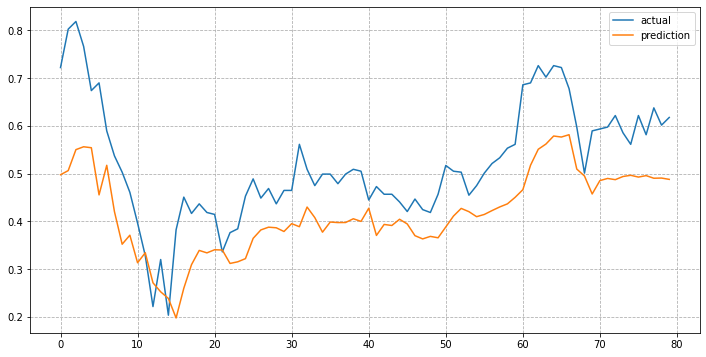

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.grid(ls='--')
plt.show()

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


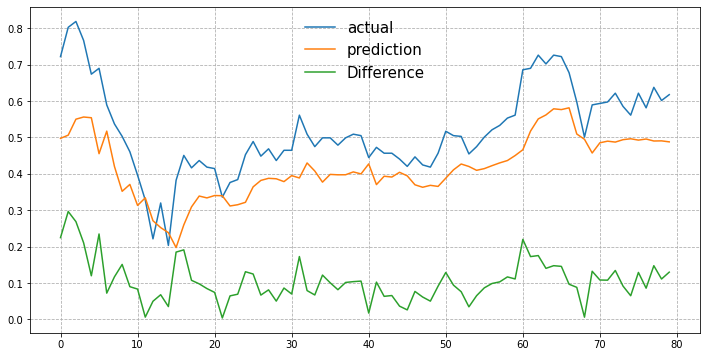

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.plot(np.sqrt((pred - test_label)**2), label='Difference')
plt.legend(frameon=False, fontsize = 15)
plt.grid(ls='--')
plt.show()

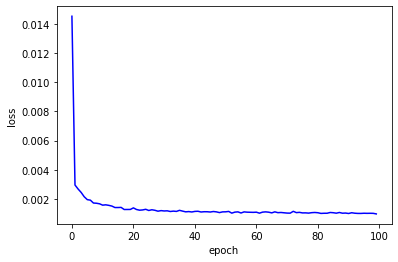

In [25]:
#훈련 손실값loss
fig, loss_ax=plt.subplots()
loss_ax.plot(history.history['loss'], 'b', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
plt.show()

In [26]:
mse=mean_squared_error(test_label, pred)
rmse=np.sqrt(mse)
rmse

0.11897217227185035

In [27]:
print(pred)

[[0.49763134]
 [0.506348  ]
 [0.55027634]
 [0.5562661 ]
 [0.55424684]
 [0.4554255 ]
 [0.51743   ]
 [0.42030644]
 [0.3520107 ]
 [0.3709431 ]
 [0.31315252]
 [0.3341309 ]
 [0.2711212 ]
 [0.25221312]
 [0.2383321 ]
 [0.19740579]
 [0.2596387 ]
 [0.30914754]
 [0.3390098 ]
 [0.33387667]
 [0.3404139 ]
 [0.339824  ]
 [0.31169668]
 [0.31514028]
 [0.32176778]
 [0.3642712 ]
 [0.38196307]
 [0.38772696]
 [0.3864529 ]
 [0.3786738 ]
 [0.39511973]
 [0.38870057]
 [0.4299491 ]
 [0.4077936 ]
 [0.37725756]
 [0.39848343]
 [0.397382  ]
 [0.39752182]
 [0.4053535 ]
 [0.39984486]
 [0.42741334]
 [0.37043646]
 [0.39345998]
 [0.39124674]
 [0.40432054]
 [0.39447346]
 [0.36992022]
 [0.36314306]
 [0.36843526]
 [0.36546943]
 [0.38818148]
 [0.41103134]
 [0.42706257]
 [0.42026582]
 [0.40973023]
 [0.41439158]
 [0.4224969 ]
 [0.43013144]
 [0.4366141 ]
 [0.45030567]
 [0.46625277]
 [0.51757133]
 [0.55101067]
 [0.56198794]
 [0.57880795]
 [0.5766645 ]
 [0.58153534]
 [0.5095624 ]
 [0.49499026]
 [0.45730475]
 [0.4853808 ]
 [0.48

In [28]:
loss, mae=model.evaluate(x_train, y_train, batch_size=1)
print(loss, mae)
#mae는 오차의 절대값: 0이 제일 정확

376/376 [==============================] - 1s 2ms/step - loss: 0.0011 - mse: 0.0011
0.001070485101081431 0.001070485101081431


Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


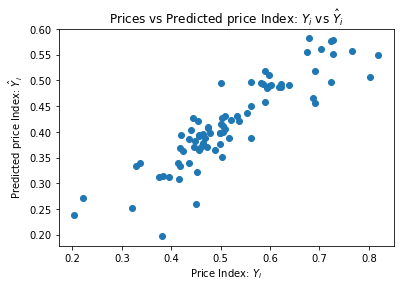

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(test_label, pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")
#예측값과 원래값이 일치하면 직선에 가깝게 분포됨

In [30]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
valScore = model.evaluate(x_valid, y_valid, verbose=0)
print('Validataion Score: ', valScore)
testScore = model.evaluate(test_feature,test_label, verbose=0)
print('Test Score: ', testScore)

Train Score:  [0.0010704853339120746, 0.0010704853339120746]
Validataion Score:  [0.019015468657016754, 0.019015468657016754]
Test Score:  [0.014154380187392235, 0.014154380187392235]
